In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [3]:
df = pd.read_csv(r"C:\Users\User\Downloads\ISIC_2019_Training_GroundTruth.csv")

Types of malignant cancer 
We would gorup the types to 3 Categories - 

    1.Melanoma
    
    2.Basal cell carcinoma
  
    Type 3 - could be benign or curable in most of the cases
    3.  #Actinic keratosis -  The patches are not usually serious / cancer
        # Dermatofibroma -  Dermatofibromas are referred to as benign fibrous 
        #Vascular lesion - may be benign (not cancer) or malignant (cancer) 
        #Squamous cell carcinoma - In general, the squamous cell carcinoma survival rate is very high

The type below are benign and were considered in the first model       
-Melanocytic nevus
-Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)

In [4]:
# Labeling the types 1 - 6

df['BCC'] = df['BCC'].replace(1.0, 2)
df['AK'] = df['AK'].replace(1.0, 3)
df['DF'] = df['DF'].replace(1.0, 3)
df['VASC'] = df['VASC'].replace(1.0, 3)
df['SCC'] = df['SCC'].replace(1.0, 3)
df['SCC'].value_counts()

0.0    24703
3.0      628
Name: SCC, dtype: int64

In [5]:
df.drop_duplicates()
df

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df1=df[['MEL','BCC','AK','DF','VASC','SCC']]
df1=df1.astype(int)

In [7]:
# Creating Label column to be used in the model


df1['LABEL']=df['MEL']+df['BCC']+df['AK']+df['DF']+df['VASC']+df['SCC']
df1['LABEL']=df1['LABEL'].astype(int)

In [8]:
df1

,MEL,BCC,AK,DF,VASC,SCC,LABEL
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1
3,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...
25326,0,2,0,0,0,0,2
25327,0,0,0,0,0,0,0
25328,1,0,0,0,0,0,1
25329,0,0,0,0,0,0,0


In [9]:
df1['LABEL'].value_counts()

0    15499
1     4522
2     3323
3     1987
Name: LABEL, dtype: int64

In [10]:
# concatinating df1 + df for images name


df2=pd.concat([df['image'],df1 ],axis=1)
df2

,image,MEL,BCC,AK,DF,VASC,SCC,LABEL
0,ISIC_0000000,0,0,0,0,0,0,0
1,ISIC_0000001,0,0,0,0,0,0,0
2,ISIC_0000002,1,0,0,0,0,0,1
3,ISIC_0000003,0,0,0,0,0,0,0
4,ISIC_0000004,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0,2,0,0,0,0,2
25327,ISIC_0073248,0,0,0,0,0,0,0
25328,ISIC_0073249,1,0,0,0,0,0,1
25329,ISIC_0073251,0,0,0,0,0,0,0


In [11]:
df_3 = df2.drop(df2[df2['LABEL']==0].index).reset_index(drop=True)


In [12]:
# counting types

df_3[['MEL','BCC','AK','DF','VASC','SCC']].value_counts()

MEL  BCC  AK  DF  VASC  SCC
1    0    0   0   0     0      4522
0    2    0   0   0     0      3323
     0    3   0   0     0       867
          0   0   0     3       628
                  3     0       253
              3   0     0       239
dtype: int64

In [13]:
df_3[['LABEL']].value_counts()

LABEL
1        4522
2        3323
3        1987
dtype: int64

In [14]:
# Creating the path for image name to concatinating with the dataset

df_3['folder']="C:\\Users\\User\\Downloads\\ISIC_2019_Training_Input\\ISIC_2019_Training_Input\\"
df_3['path']=(df_3['folder']+df_3['image'])+".jpg"
df_3['path']

0       C:\Users\User\Downloads\ISIC_2019_Training_Inp...
1       C:\Users\User\Downloads\ISIC_2019_Training_Inp...
2       C:\Users\User\Downloads\ISIC_2019_Training_Inp...
3       C:\Users\User\Downloads\ISIC_2019_Training_Inp...
4       C:\Users\User\Downloads\ISIC_2019_Training_Inp...
                              ...                        
9827    C:\Users\User\Downloads\ISIC_2019_Training_Inp...
9828    C:\Users\User\Downloads\ISIC_2019_Training_Inp...
9829    C:\Users\User\Downloads\ISIC_2019_Training_Inp...
9830    C:\Users\User\Downloads\ISIC_2019_Training_Inp...
9831    C:\Users\User\Downloads\ISIC_2019_Training_Inp...
Name: path, Length: 9832, dtype: object

In [15]:
df_3['JPG'] = df_3['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))
df_3


,image,MEL,BCC,AK,DF,VASC,SCC,LABEL,folder,path,JPG
0,ISIC_0000002,1,0,0,0,0,0,1,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[17, 17, 17], [10, 10, 9], [14, 15, 17], [39..."
1,ISIC_0000004,1,0,0,0,0,0,1,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[13, 13, 13], [7, 7, 7], [8, 8, 8], [8, 8, 8..."
2,ISIC_0000013,1,0,0,0,0,0,1,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[195, 194, 202], [207, 206, 214], [215, 215,..."
3,ISIC_0000022_downsampled,1,0,0,0,0,0,1,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[128, 124, 126], [135, 130, 133], [140, 136,..."
4,ISIC_0000026_downsampled,1,0,0,0,0,0,1,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[144, 136, 149], [150, 142, 157], [153, 142,..."
...,...,...,...,...,...,...,...,...,...,...,...
9827,ISIC_0073238,1,0,0,0,0,0,1,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[182, 164, 139], [181, 164, 138], [183, 166,..."
9828,ISIC_0073241,1,0,0,0,0,0,1,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[30, 23, 21], [56, 39, 36], [74, 50, 46], [8..."
9829,ISIC_0073246,0,2,0,0,0,0,2,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ..."
9830,ISIC_0073247,0,2,0,0,0,0,2,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


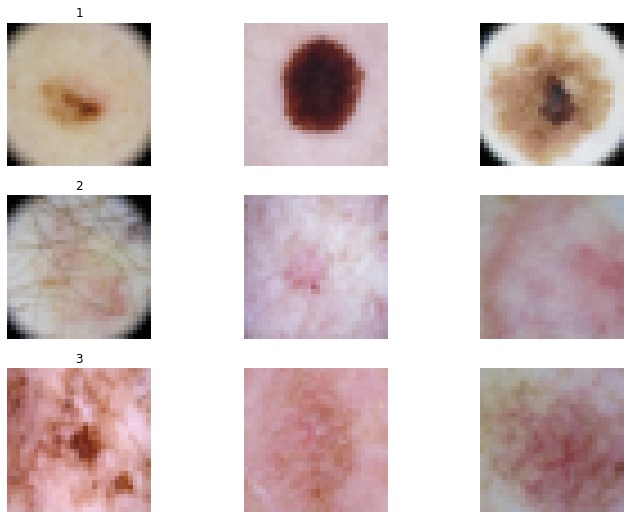

In [19]:
n_samples = 3  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(3, n_samples, figsize = (4*n_samples, 3*3))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df_3.sort_values(['LABEL']).groupby('LABEL')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['JPG'])
        c_ax.axis('off')

In [111]:
# Shuflling and reseting index

df_3=df_3.sample(frac=1)
df_3=df_3.reset_index(drop=True)
df_3

,image,MEL,BCC,AK,DF,VASC,SCC,LABEL,folder,path,JPG
0,ISIC_0058278,0,2,0,0,0,0,2,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [1, 1, 1], ..."
1,ISIC_0032220,1,0,0,0,0,0,1,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[173, 126, 109], [186, 135, 117], [195, 148,..."
2,ISIC_0015045_downsampled,1,0,0,0,0,0,1,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[188, 195, 192], [196, 199, 193], [209, 212,..."
3,ISIC_0065888,0,0,0,0,0,3,3,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[2, 2, 2], [9, 9, 9], [22, 22, 23], [41, 41,..."
4,ISIC_0030784,1,0,0,0,0,0,1,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[190, 152, 151], [196, 159, 156], [197, 159,..."
...,...,...,...,...,...,...,...,...,...,...,...
9827,ISIC_0061674,0,0,0,0,3,0,3,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[1, 1, 2], [15, 13, 11], [65, 49, 38], [115,..."
9828,ISIC_0060198,0,2,0,0,0,0,2,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[186, 163, 152], [184, 155, 141], [182, 152,..."
9829,ISIC_0060749,1,0,0,0,0,0,1,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
9830,ISIC_0025800,1,0,0,0,0,0,1,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[207, 182, 191], [214, 187, 196], [218, 193,..."


In [112]:
# Preparing the model 

X = np.asarray(df_3['JPG'].tolist())
X = X/255  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=df_3[['LABEL']]  #Assign label values to Y
#Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [113]:
Y

,LABEL
0,2
1,1
2,1
3,3
4,1
...,...
9827,3
9828,2
9829,1
9830,1


In [114]:
import autokeras as ak

In [115]:
# Autokeras modeling

clf = ak.ImageClassifier(
    overwrite=True,
    max_trials=1)
# Feed the image classifier with training data.
history = clf.fit(x_train, y_train)

Trial 1 Complete [00h 03m 04s]
val_loss: 0.7280485033988953

Best val_loss So Far: 0.7280485033988953
Total elapsed time: 00h 03m 04s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/13
231/231 [==============================] - 12s 49ms/step - loss: 0.8561 - accuracy: 0.6056
Epoch 2/13
231/231 [==============================] - 11s 50ms/step - loss: 0.7660 - accuracy: 0.6611
Epoch 3/13
231/231 [==============================] - 12s 51ms/step - loss: 0.7359 - accuracy: 0.6753
Epoch 4/13
231/231 [==============================] - 12s 50ms/step - loss: 0.7048 - accuracy: 0.6935
Epoch 5/13
231/231 [==============================] - 12s 51ms/step - loss: 0.6888 - accuracy: 0.7018
Epoch 6/13
231/231 [==============================] - 12s 51ms/step - loss: 0.6664 - accuracy: 0.7114
Epoch 7/13
231/231 [==============================] - 11s 49ms/step - loss: 0.6458 - accuracy: 0.7143
Epoch 8/13
231/231 [==============================] - 11s 49ms/step - loss: 0.6319 - accuracy: 0.7276
Epoch 9/13
231/231 [==============================] - 12s 50ms/step - loss: 0.6144 - accuracy: 0.7383
Epoch 10/13
231/231 [==============================] - 11s 49ms/step - loss: 0.596

INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets


INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets


In [116]:
# Model output

model = clf.export_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 32, 32, 3)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 32, 32, 3)        7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0     

In [117]:
# model evaluation

print(clf.evaluate(x_test, y_test))

77/77 [==============================] - 1s 9ms/step - loss: 0.6868 - accuracy: 0.7038
[0.6868424415588379, 0.7038242220878601]


In [164]:
y=df_3

x=y['JPG'].sample(1)
image  = np.asarray(x.tolist())

predicted_y = clf.predict(image)




print('Actual type:',y['LABEL'].iloc[x.index[0]])
print('Predicted type:')
#print(x1)
#print(round(x1.max()))
#classes = np.argmax(predicted_y, axis = 1)
#if predicted_y == 0:
    #print('NO')
#if predicted_y == 1:
    #print('YES')
# print(predicted_y)
print(predicted_y)

1/1 [==============================] - 0s 9ms/step
Actual type: 1
Predicted type:
[['2']]


In [121]:
y_pred=clf.predict(x_test)

77/77 [==============================] - 1s 8ms/step


In [125]:
y_pred = clf.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors


77/77 [==============================] - 1s 9ms/step


In [127]:
y_true

,LABEL
4477,0
2147,0
518,0
7199,0
1851,0
...,...
8016,0
9350,0
5467,0
1860,0


In [133]:
pd.DataFrame(y_test).value_counts()

LABEL
1        1110
2         855
3         493
dtype: int64

In [141]:
y_pred=(y_pred).astype(int)

<AxesSubplot:>

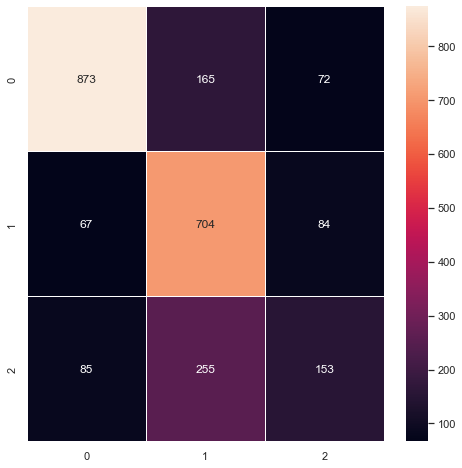

In [143]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8,8))
sns.set(font_scale=1)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax, fmt="d")

In [146]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

In [147]:
accuracy

0.7038242473555736

In [182]:
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred,average='macro')
recall

0.6400743756460635